
# S2orc (exploration, clustering & visualization)
---
---
For presenting some results we need to analyze (and rapidly compare) some of the methods we used untill now in order to discriminates between paper's `field_of_study` based on their `title` and `abstract`.
This notebook is an extention of some previous work done by Master's students from University of Florence (cite here).

## 1. Dataset
---

From each scientific paper we took the `title` and the `abstract`, as well as a property identifying the field in witch the article pertrains.
The dataset (only 1000 elements) has been selected randomly from a full-version of 80M papers from different fields.
The field of studies (that are called in the dataset `mag_field_of_study`) are the following:

| Field of study | All papers | Full text |
|----------------|------------|-----------|
| Medicine       | 12.8M      | 1.8M      |
| Biology        | 9.6M       | 1.6M      |
| Chemistry      | 8.7M       | 484k      |
| n/a            | 7.7M       | 583k      |
| Engineering    | 6.3M       | 228k      |
| Comp Sci       | 6.0M       | 580k      |
| Physics        | 4.9M       | 838k      |
| Mat Sci        | 4.6M       | 213k      |
| Math           | 3.9M       | 669k      |
| Psychology     | 3.4M       | 316k      |
| Economics      | 2.3M       | 198k      |
| Poli Sci       | 1.8M       | 69k       |
| Business       | 1.8M       | 94k       |
| Geology        | 1.8M       | 115k      |
| Sociology      | 1.6M       | 93k       |
| Geography      | 1.4M       | 58k       |
| Env Sci        | 766k       | 52k       |
| Art            | 700k       | 16k       |
| History        | 690k       | 22k       |
| Philosophy     | 384k       | 15k       |


Note for reproducibility: `data` is a `DatasetDict` object composed by `Dataset` object for every key (in `train`, `test`, `valid`):

```python
{
    "train": Dataset,
    "test" : Dataset,
    "valid": Dataset
}
```


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from typing import List, Tuple, Dict
import os
import wandb

from thesis.parsers.args_parser import parse_args
from thesis.parsers.utils import split_args, tag_generation
from thesis.utils.classes import DotDict
from sentence_transformers import SentenceTransformer
from thesis.utils.functions import get_dict_args

from thesis.datasets.utils import format_key_names, fuse_datasets_splits, getting_dataset_splitted, select_concat_fields

from thesis.utils.constants import (
    ARGS_PATH,
    ARGS_FILE,
    DICTIONARY_FIELD_NAMES,
    _factory_MODELS
)

from thesis.visualization.dim_reduction import pre_reduction, post_reduction
from thesis.visualization.clusterization import clusterization
from thesis.visualization.utils import visualization
from thesis.config.visual import VisualConfig

from simple_parsing import ArgumentParser
from dataclasses import dataclass, field

# Parsers
from thesis.parsers.classes import (
    DataTrainingArguments,
    ModelArguments,
    TrainingArguments,
    EmbeddingArguments,
    DimRedArguments,
    ClustArguments,
    VisualArguments,
    RunArguments,
    LoggingArguments
)

import logging
from thesis.utils.load_dataset import load_dataset_wrapper
from thesis.utils.constants import DICTIONARY_FIELD_NAMES

from torch.utils.data import DataLoader

import pandas as pd

from thesis.datasets.s2orc.mag_field import mag_field_dict

For reasonable computation time, install Multicore-TSNE!


[   Str    ] type(args_) is str: file_name=args_=/home/vivoli/Thesis/args/args.yaml
[   Str    ] type(args_) is <class 'str'>: parses_args:Args(datatrain=DataTrainingArguments(dataset_path='/home/vivoli/Thesis/data', dataset_name='s2orc', dataset_config_name='sample', train_file=None, validation_file=None, validation_split_percentage=5, data=['abstract'], target=['title'], classes=['mag_field_of_study'], pad_to_max_length=False, use_slow_tokenizer=None, overwrite_cache=False, max_seq_length=512, preprocessing_num_workers=None, mlm_probability=0.15, line_by_line=False, max_train_samples=None, max_eval_samples=None, s2orc=S2orcArguments(idxs=[0], zipped=True, mag_field_of_study=[], keep_none_papers=False, keep_unused_columns=False), keyph=KeyPhArguments(), journ=JournArguments()), training=TrainingArguments(seed=1234, do_train=False, do_eval=False, do_predict=False, output_dir='/home/vivoli/Thesis/output', overwrite_output_dir=False, num_train_epochs=1, max_train_steps=5, per_device_trai

  0%|          | 0/499 [00:00<?, ?ex/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

[ BASE EMB ]: (499, 768)   | allenai/scibert_scivocab_uncased on ['abstract']
[ PRE  EMB ]: (499, 50)   | UMAP
[ labels   ]: (499,)       | KMEANS
[ POST EMB ]: (499,), (499,) | UMAP
[ pic  EMB ]: d:25-05-2021-09-31-00_Fie::abstract_Net::allenai:scibert.scivocab.uncased_PREa::UMAP:15:50:cosine_Clu::KMEANS:POSTa::UMAP:15:2:cosine:0_.png


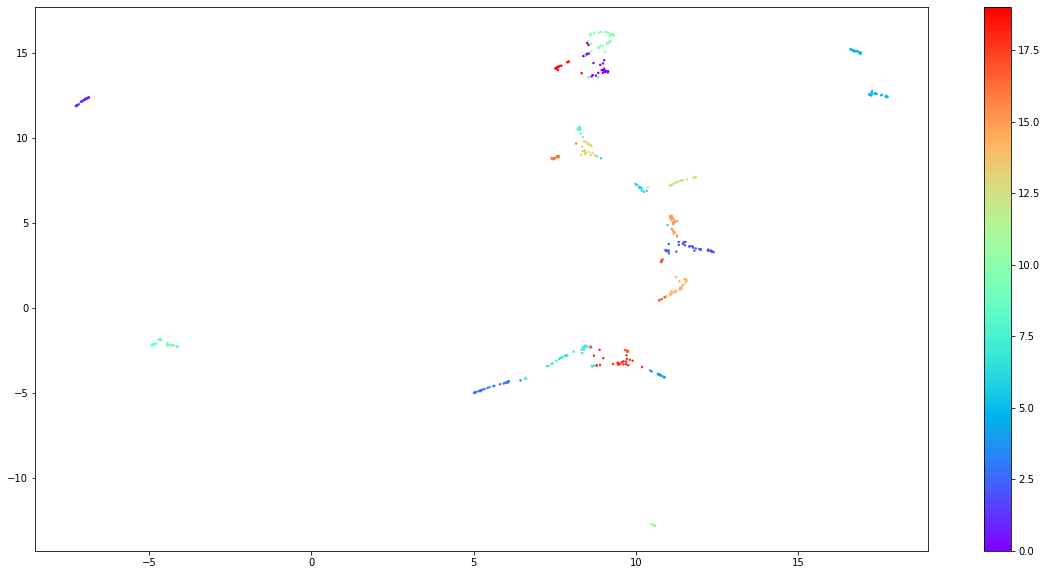

In [3]:
# ------------------
# Parsing the Arguments
# ------------------
args = parse_args(os.path.join(ARGS_PATH, 'args.yaml'))
# dataset_args, training_args, model_args, embedding_args, visual_args, run_args, log_args = split_args(args)

# ------------------
# Init the wandb
# ------------------
tags = tag_generation(args)
# Pass them to wandb.init
wandb.init(
    project="thesis",
    notes="Try out the visualization baselines",
    tags=["visualization"]+tags,
    config=args,
)
# Access all hyperparameter values through wandb.config
config = wandb.config


# ------------------
# Getting the datasets
# ------------------
# Getting the load_dataset wrapper that manages huggingface dataset and the custom ones
custom_load_dataset = load_dataset_wrapper()
# Loading the raw data based on input (and default) values of arguments
raw_datasets = custom_load_dataset(args)

# The Datasets in the raw form can have different form of key names (depending on the configuration).
# We need all datasets to contain 'train', 'test', 'validation' keys, if not we change the dictionary keys' name
# based on the `names_tuple` and conseguently on `names_map`.
logging.info(f"Formatting DatasetDict keys")
datasets = format_key_names(raw_datasets)

# The Dataset comes with train/test/validation splits.
# As we need only one field the next step is to fude them together
s2orc_chunk = fuse_datasets_splits(datasets)

# We want to access to dictionary with Dot notation (dict.field)
# instead of the String one (dict['field'])
# args_ = DotDict(args)
args_ = args

corpus = select_concat_fields(s2orc_chunk, args.visual.fields)

# ------------------
# Clustering Creation
# & Visualization
# ------------------
def embedd(args, corpus):
    model = SentenceTransformer(args.model.model_name_or_path)
    model.max_seq_length = 512 if model.max_seq_length is None else model.max_seq_length

    embeddings = model.encode(corpus, show_progress_bar=True)
    return embeddings

embeddings = embedd(args_, corpus)
print(
    f"[ BASE EMB ]: {embeddings.shape}   | {args_.model.model_name_or_path} on {args_.visual.fields}")

embeddings = pre_reduction(args_.visual, embeddings)
print(f"[ PRE  EMB ]: {embeddings.shape}   | {args_.visual.pre.choice}")

labels = clusterization(args_.visual, embeddings)
print(f"[ labels   ]: {labels.shape}       | {args_.visual.clust.choice}")

x, y = post_reduction(args_.visual, embeddings)
print(f"[ POST EMB ]: {x.shape}, {y.shape} | {args_.visual.post.choice}")

name = visualization(args_,  x, y, labels)
print(f"[ pic  EMB ]: {name}")


In [4]:
dict_len = {}
for length in [len(mag) for mag in s2orc_chunk['mag_field_of_study']]:
    dict_len[length] = dict_len.get(length, 0) + 1
print(dict_len)

{1: 435, 2: 60, 3: 4}


## 2. Embeddings
___

Here we test multiple embedding BERT-based networks and cluster those embeddings with multiple clustering algorithms. Once we got the clusters we can visualize them using various dimentionality reduction algorithms.

### 2.2 Clustering
---

# VISUAL pipeline
---

In [5]:
clustered_sentences = [[] for i in range(len(set(labels)))]
for sentence_id, cluster_id in enumerate(labels):
    clustered_sentences[cluster_id].append(corpus[sentence_id])


### 2.3 Topic Exploration
---
We aim to see what kind of topics are presents.

In [8]:
# ------------------
# Table Creation
# ------------------
# clustered_sentences = [[] for i in range(len(set(labels)))]
# for sentence_id, cluster_id in enumerate(labels):
#     clustered_sentences[cluster_id].append(corpus[sentence_id])

dataframe = {
    "mag": mag_field_dict.keys(),
    "TOT": [0 for _ in mag_field_dict.keys()]
}
for cluster_id in list(set(labels)):
    dataframe[f'cluster {cluster_id}'] = [0 for _ in mag_field_dict.keys()]

df = pd.DataFrame(dataframe)

for cluster_id, mag_list in zip(labels, s2orc_chunk['mag_field_of_study']):
    for mag in mag_list:
        df['TOT'][mag_field_dict[mag]] += 1
        df[f'cluster {cluster_id}'][mag_field_dict[mag]] += 1

app = df.append(df.sum(axis=0), ignore_index=True)
app['mag'][20] = 'TOT'
print(app)

                      mag  TOT  cluster 0  cluster 1  cluster 2  cluster 3  \
0                Medicine   91          5          5          1          1   
1                 Biology   77          0          2          0         25   
2               Chemistry   68          1          3          4          1   
3                    null    0          0          0          0          0   
4             Engineering   19          2          2          5          0   
5        Computer Science   52          3          2          0          0   
6                 Physics  111          0          2         21          1   
7       Materials Science   16          0          0          5          0   
8             Mathematics   50          0          1          2          0   
9              Psychology   25          3          3          0          0   
10              Economics    7          4          0          0          0   
11      Political Science   16          5          2          0 

### 2.4 Topic Creation
---
We explore how to generate topic from clustered `documents` (more precisely, from abstract/title/both).

#### c-TF-IDF

In [7]:
# ------------------
# Clustered
# TF-IDF
# ------------------
docs_df = pd.DataFrame(corpus, columns=["Doc"])
docs_df['Topic'] = labels
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(
    ['Topic'], as_index=False).agg({'Doc': ' '.join})

import numpy as np

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range,
                            stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(corpus))

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = np.round(np.asarray(tf_idf.T), 3)
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j])
                            for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                    .Doc
                    .count()
                    .reset_index()
                    .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                    .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(
    tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
print(topic_sizes)

app = pd.DataFrame.from_records(top_n_words)
print(app)

for topic in range(len(top_n_words)):
    print(pd.DataFrame([x[0] for x in top_n_words[topic][:10]]))
    print('\n\n')


    Topic  Size
10     10    40
5       5    40
7       7    36
2       2    34
9       9    32
0       0    30
3       3    29
14     14    29
18     18    26
13     13    25
1       1    24
12     12    24
15     15    23
4       4    17
16     16    17
17     17    17
8       8    16
19     19    14
6       6    13
11     11    13
                        0                    1                     2   \
0            (trust, 0.02)          (丙子日錄, nan)        (field, 0.017)   
1           (state, 0.019)     (establish, nan)           (μm, 0.016)   
2             (tax, 0.018)     (essential, nan)          (gan, 0.015)   
3             (law, 0.017)        (essays, nan)      (surface, 0.014)   
4         (chinese, 0.016)    (especially, nan)      (optical, 0.014)   
5        (students, 0.016)           (esi, nan)   (wavelength, 0.013)   
6         (housing, 0.014)      (escorted, nan)        (probe, 0.013)   
7       (temporary, 0.014)   (escherichia, nan)   (excitation, 0.012)   
8      